# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# !pip install eli5==0.13.0
# !pip install xgboost

# # 한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum

In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic') 
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

pd.options.display.float_format = '{:.2f}'.format


## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# # 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
# train_path = '/data/ephemeral/home/data/train.csv'
# test_path  = '/data/ephemeral/home/data/test.csv'
# dt = pd.read_csv(train_path)
# dt_test = pd.read_csv(test_path)

In [4]:
concat_coordinate = '/data/ephemeral/home/data/concat_coordinate.csv'
concat = pd.read_csv(concat_coordinate)

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [5]:
# # train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# dt['is_test'] = 0
# dt_test['is_test'] = 1
# concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [6]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

In [7]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

concat = concat.drop(columns=['Unnamed: 0'], axis=1)


concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [8]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

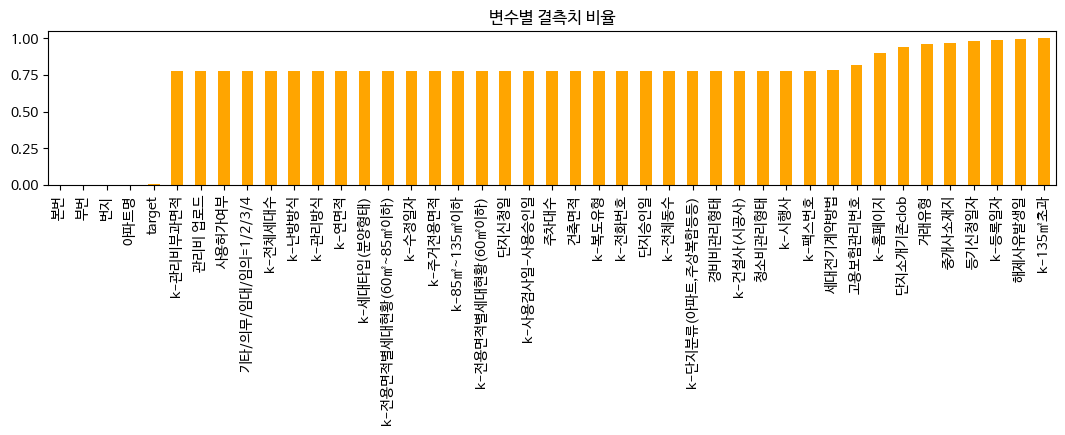

In [9]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [10]:
# Null값이 50만개 이상인 칼럼은 삭제해보도록 하겠습니다. (결측치 50% 이상상)
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 500000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 500000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [11]:
# 위에서 결측치가 50만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 500000])
concat_select = concat[selected]

In [12]:
concat_select.isnull().sum()     # 결측치가 50만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
좌표X           0
좌표Y           0
target     9272
is_test       0
dtype: int64

이 columns중, 시군구, 번지, 본번 부번, 도로명, xy좌표는 모두 위치 정보에 속한다. (상관관계 + 인과관계)  
따라서 일부 결측치가 있는 번지, 본번 부번을 삭제하고, 도로명을 삭제한다.

In [13]:
concat_select = concat_select.drop(columns=['번지', '본번', '부번', '도로명'], axis=1)
print(concat_select.columns)


Index(['시군구', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y',
       'target', 'is_test'],
      dtype='object')


### 결측치 보간
연속형 변수 남은게 ['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', '주차대수'] 인데, 상관계수가 무척 높은 4개가 있기 때문에 선형 보간은 맞지 않다고 판단.
KNN 보간을 한 이후 상관 관계가 크게 나오는 값들 몇개를 쳐 내는게 낫다고 생각.  
시간이 너무 오래걸림. 다른 보간법은 포기하고 선형보간법으로 해야 함. 

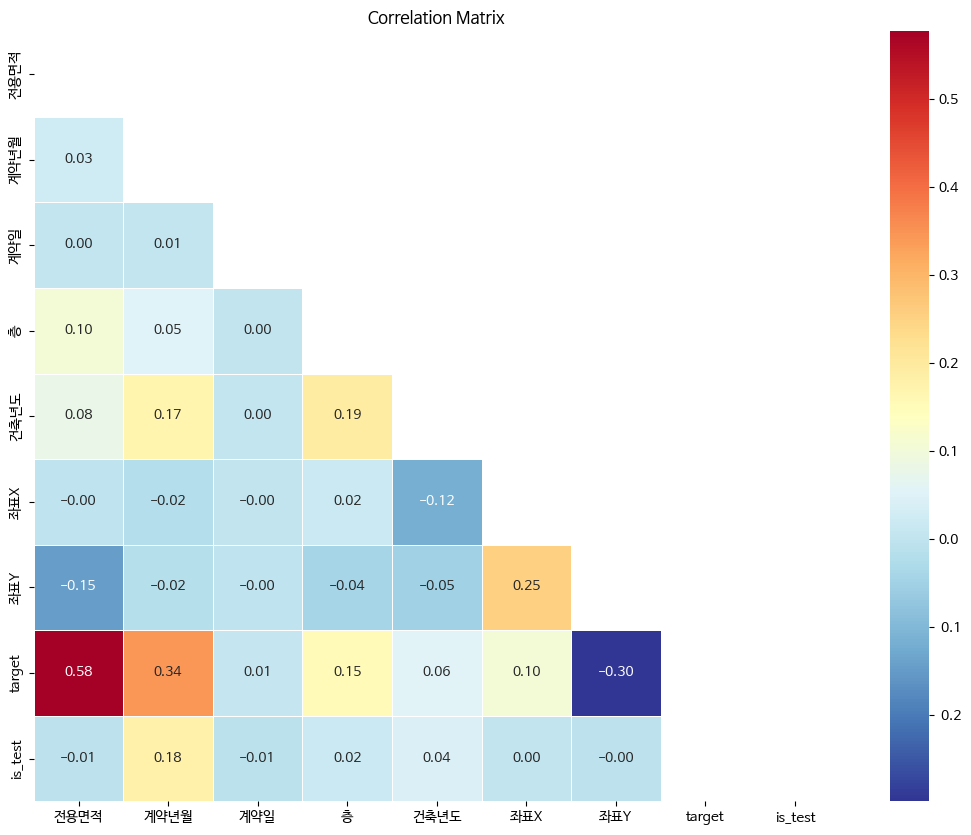

In [14]:
# 데이터의 상관계수 행렬을 생성
corr = concat_select.corr(numeric_only=True)  # 데이터셋으로부터 각 변수별 상관계수를 계산하여 행렬형태로 나타내는 함수. 여기서는 피어슨 상관계수를 이용
# numeric_only는 숫자형 변수만 상관계수를 계산하도록 하는 옵션
# figure에서 생략될 부분을 지정하는 mask 행렬을 생성 - 실제로는 mask 없이 다 생성해도 괜찮습니다.
mask = np.ones_like(corr, dtype=bool)
mask = np.triu(mask)

# 시각화될 그림의 크기를 지정
# 히트맵 형태로 상관행렬 시각화하기
plt.figure(figsize=(13,10))
sns.heatmap(data=corr, annot=True, fmt='.2f', mask=mask, linewidths=.5, cmap='RdYlBu_r')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 변수의 형태 확인
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 11 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   아파트명     1125958 non-null  object 
 2   전용면적     1128094 non-null  float64
 3   계약년월     1128094 non-null  int64  
 4   계약일      1128094 non-null  int64  
 5   층        1128094 non-null  int64  
 6   건축년도     1128094 non-null  int64  
 7   좌표X      1128094 non-null  float64
 8   좌표Y      1128094 non-null  float64
 9   target   1118822 non-null  float64
 10  is_test  1128094 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 94.7+ MB


In [16]:
# # 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
# concat_select['본번'] = concat_select['본번'].astype('str')
# concat_select['부번'] = concat_select['부번'].astype('str')

In [ ]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '아파트명']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [18]:
# 보간 전 상태 확인인
concat_select.isnull().sum()

시군구           0
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
좌표X           0
좌표Y           0
target     9272
is_test       0
dtype: int64

In [19]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

In [20]:
# 연속형 변수에 대한 선형 보간 (이미 모든 결측치를 처리 했기 때문에 할 필요가 없음)
# concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear')

In [21]:
# target의 경우 test data는 모두 결측치로 확인 되기 때문에 0을 채워 넣음
concat_select['target'] = concat_select['target'].fillna(0)

In [22]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구        0
아파트명       0
전용면적       0
계약년월       0
계약일        0
층          0
건축년도       0
좌표X        0
좌표Y        0
target     0
is_test    0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

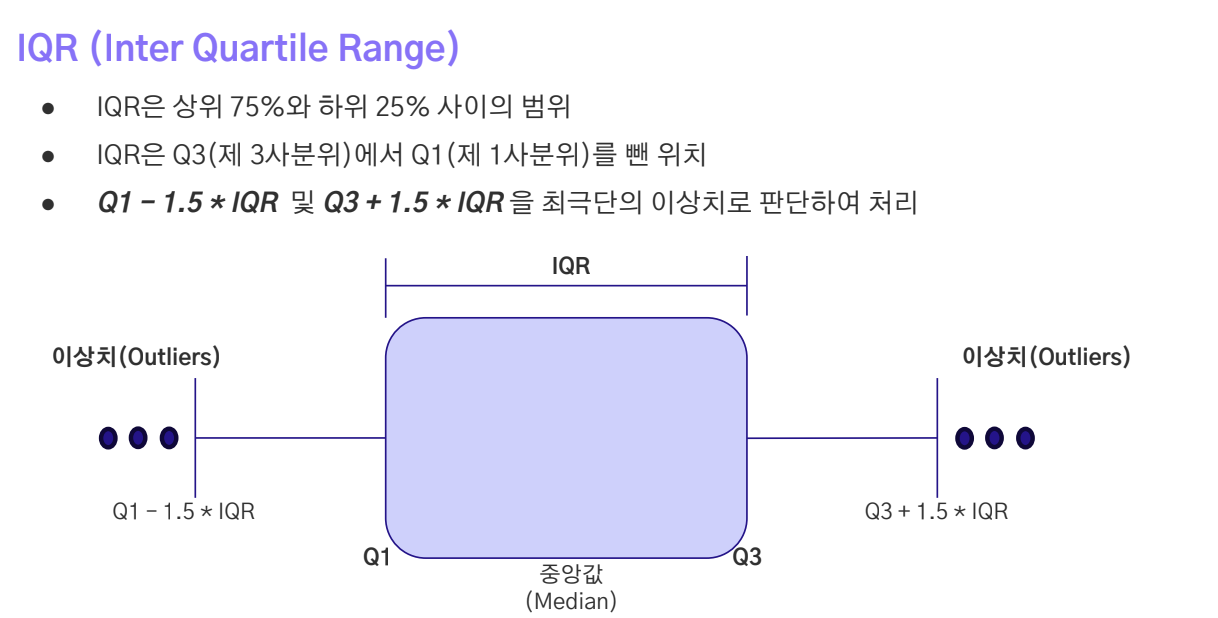

In [23]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 11)


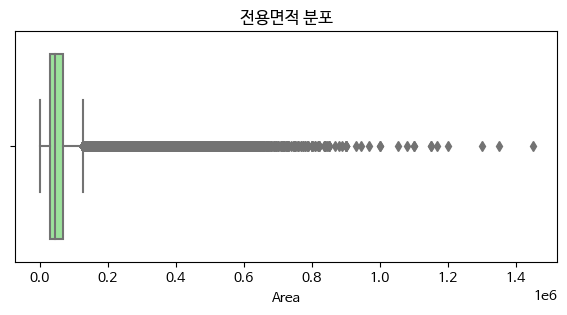

In [24]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 IQR을 통해 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = 'target', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

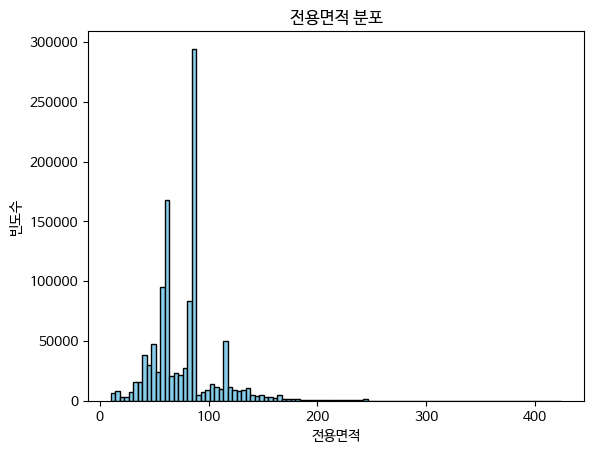

In [25]:
plt.hist(concat_select['전용면적'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('전용면적')
plt.ylabel('빈도수')
plt.title('전용면적 분포')
plt.show()

In [26]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
print(concat_select['전용면적'].quantile(percentiles))
print(concat_select['전용면적'].describe())

0.10    45.12
0.25    59.65
0.50    81.87
0.75    84.96
0.90   114.87
Name: 전용면적, dtype: float64
count   1128094.00
mean         77.16
std          29.36
min          10.02
25%          59.65
50%          81.87
75%          84.96
max         424.32
Name: 전용면적, dtype: float64


대부분의 값이 250이하에서 머물러 있는 모습을 볼 수 있다. 또한 0이하의 값이 있는 것은 말이 안되니 전용면적 x의 값은  
0 <= x <= 250  
으로 설정하고 이 범위 밖의 값들을 이상치로 처리하는 것이 좋아 보인다.

In [27]:
# IQR 기반 이상치 개수 계산
def count_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')  # train data 내에서 이상치 개수를 확인합니다.

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치 조건
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    
    return len(outliers)

# "전용면적" 변수의 이상치 개수 확인
outlier_count = count_outliers_iqr(concat_select, '전용면적')
print(f"이상치 개수: {outlier_count}")

이상치 개수: 89248


In [28]:
# is_test == 1인 데이터는 항상 포함
test_data = concat_select[concat_select['is_test'] == 1]

# 조건에 따른 필터링 (is_test가 0인 경우만 조건 적용)
in_range = concat_select[
    (concat_select['전용면적'] >= 0) & 
    (concat_select['전용면적'] <= 250) & 
    (concat_select['is_test'] == 0)
]

# 범위 밖의 값 확인 (is_test가 0인 경우만 포함)
out_of_range = concat_select[
    ((concat_select['전용면적'] < 0) | (concat_select['전용면적'] > 250)) & 
    (concat_select['is_test'] == 0)
]

# 개수 확인
print(f"0부터 250까지의 값 개수 (is_test 제외): {len(in_range)}")
print(f"범위 밖의 값 개수 (is_test 제외): {len(out_of_range)}")

# 필터링된 데이터와 is_test == 1 데이터를 합침
concat_select = pd.concat([in_range, test_data])

# 최종 데이터프레임 크기 확인
print(concat_select.shape)


0부터 250까지의 값 개수 (is_test 제외): 1118578
범위 밖의 값 개수 (is_test 제외): 244
(1127850, 11)


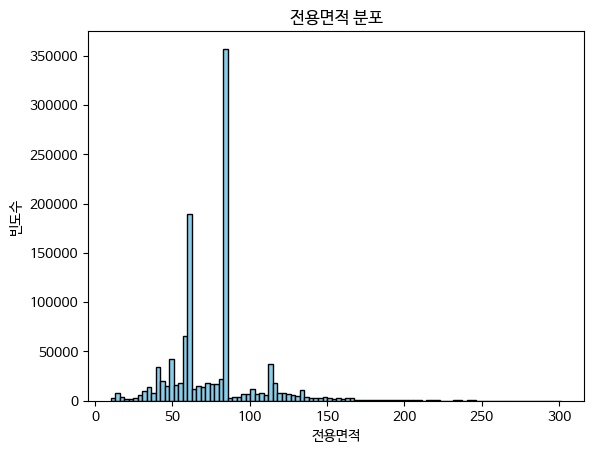

In [29]:
plt.hist(concat_select['전용면적'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('전용면적')
plt.ylabel('빈도수')
plt.title('전용면적 분포')
plt.show()

In [30]:
concat_select['전용면적'] = np.sqrt(concat_select['전용면적'])

In [31]:
# '전용면적'을 20씩 묶어 새로운 'size' 열 추가
concat_select['size'] = pd.cut(
    concat_select['전용면적'], 
    bins=range(0, int(concat_select['전용면적'].max()) + 20, 20),  # 최대값을 정수로 변환
    labels=range(1, (int(concat_select['전용면적'].max()) // 20) + 2),  # 각 구간에 1, 2, 3,... 번호 할당
    right=False  # 구간의 우측 끝값을 제외하도록 설정
)

# 결과 확인
print(concat_select[['전용면적', 'size']].head())

   전용면적 size
0  8.94    1
1  8.94    1
2  7.41    1
3  8.94    1
4  8.94    1


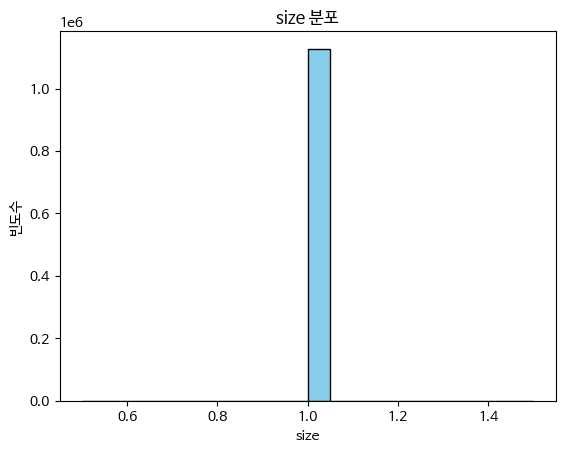

In [32]:
plt.hist(concat_select['size'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('size')
plt.ylabel('빈도수')
plt.title('size 분포')
plt.show()

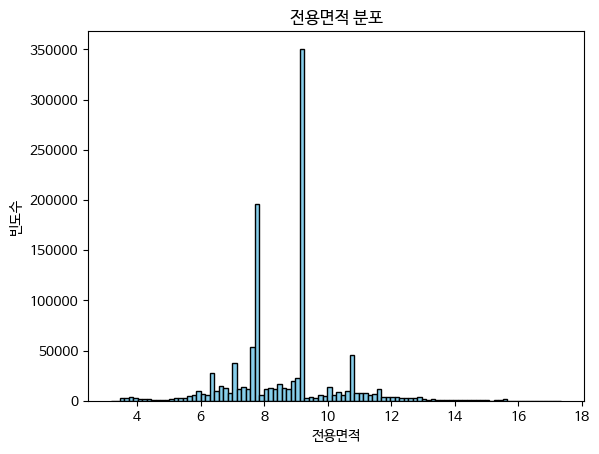

In [33]:
plt.hist(concat_select['전용면적'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('전용면적')
plt.ylabel('빈도수')
plt.title('전용면적 분포')
plt.show()

In [34]:
# # 이상치 제거 방법에는 IQR을 이용하겠습니다.
# def remove_outliers_iqr(dt, column_name):
#     df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
#     df_test = dt.query('is_test == 1')

#     Q1 = df[column_name].quantile(0.25)
#     Q3 = df[column_name].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

#     result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
#     return result

In [35]:
# # 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
# concat_select = remove_outliers_iqr(concat_select, '전용면적')
..

### 층 이상치 확인

In [36]:
print(concat_select['층'].describe())

count   1127850.00
mean          8.88
std           5.99
min          -4.00
25%           4.00
50%           8.00
75%          12.00
max          69.00
Name: 층, dtype: float64


층에 대한 정보인데 -4가 나오는게 가능한...가...?

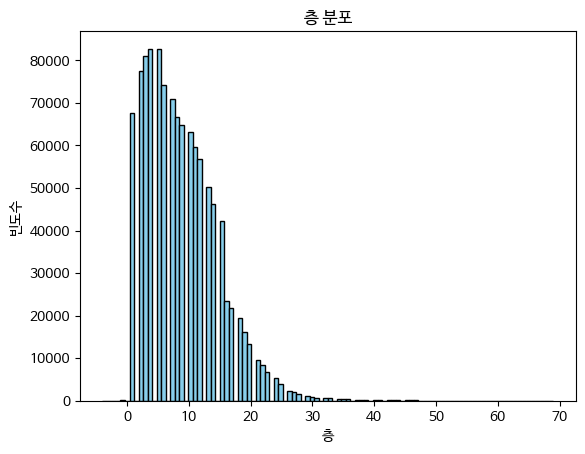

In [37]:
plt.hist(concat_select['층'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('층')
plt.ylabel('빈도수')
plt.title('층 분포')
plt.show()

In [38]:
# is_test == 1인 데이터는 항상 포함
test_data = concat_select[concat_select['is_test'] == 1]

# 조건에 따른 필터링 (is_test가 0인 경우만 조건 적용)
in_range = concat_select[
    (concat_select['층'] >= 0) & 
    (concat_select['층'] <= 40) & 
    (concat_select['is_test'] == 0)
]

# 범위 밖의 값 확인 (is_test가 0인 경우만 포함)
out_of_range = concat_select[
    ((concat_select['층'] < 0) | (concat_select['층'] > 40)) & 
    (concat_select['is_test'] == 0)
]

# 개수 확인
print(f"0부터 40까지의 값 개수 (is_test 제외): {len(in_range)}")
print(f"범위 밖의 값 개수 (is_test 제외): {len(out_of_range)}")

# 필터링된 데이터와 is_test == 1 데이터를 합침
concat_select = pd.concat([in_range, test_data])

# 최종 데이터프레임 크기 확인
print(concat_select.shape)


0부터 40까지의 값 개수 (is_test 제외): 1117284
범위 밖의 값 개수 (is_test 제외): 1294
(1126556, 12)


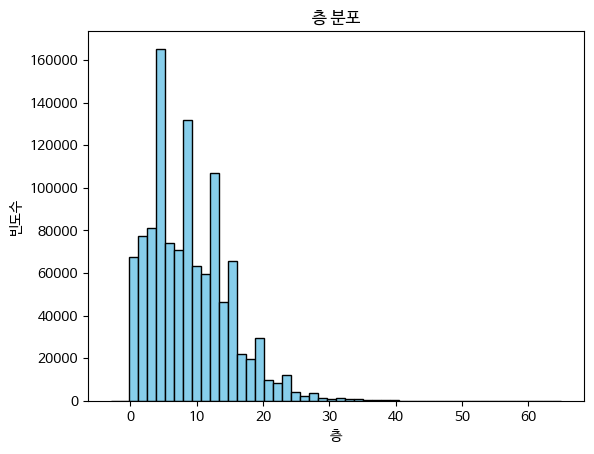

In [39]:
plt.hist(concat_select['층'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('층')
plt.ylabel('빈도수')
plt.title('층 분포')
plt.show()

In [40]:
concat_select['층'] = np.log(concat_select['층'])

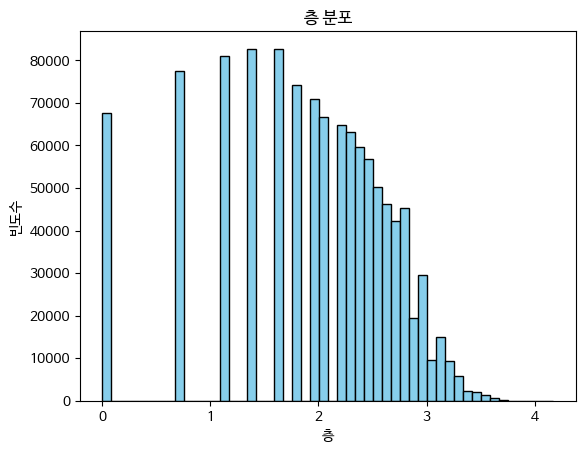

In [41]:
plt.hist(concat_select['층'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('층')
plt.ylabel('빈도수')
plt.title('층 분포')
plt.show()

초고층 빌딩의 경우 층의 수가 특별히 많은 경우에 속하기 때문에 일반적인 아파트 실거래가 측정에 방해되는 요소이다.  
따라서 임의로 제거한다.

# 

In [42]:
# concat_select = concat_select[
#     ~((concat_select['is_test'] == 0) & 
#       ((concat_select['층'] > 50) | (concat_select['target'] > 510000)))
# ]

In [43]:
# concat_select = concat_select[(concat_select['층'] < 50) & (concat_select['is_test'] == 0)]
# concat_select = concat_select[(concat_select['target'] < 510000) & (concat_select['is_test'] == 0)]

# concat_select.loc[concat_select['is_test'] == 0, :] = concat_select.loc[
#     (concat_select['is_test'] == 0) & (concat_select['층'] <= 50)
# ]


In [44]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1126556, 12)


In [45]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.(1038846, 45)

0    1117284
1       9272
Name: is_test, dtype: int64

전체적으로 층이랑 전용면적 모두 왼쪽으로 치우쳐져 있는 것을 확인할 수 있음. 이에 따라 log 변환을 해주는 것에 대해 고민


## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [46]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

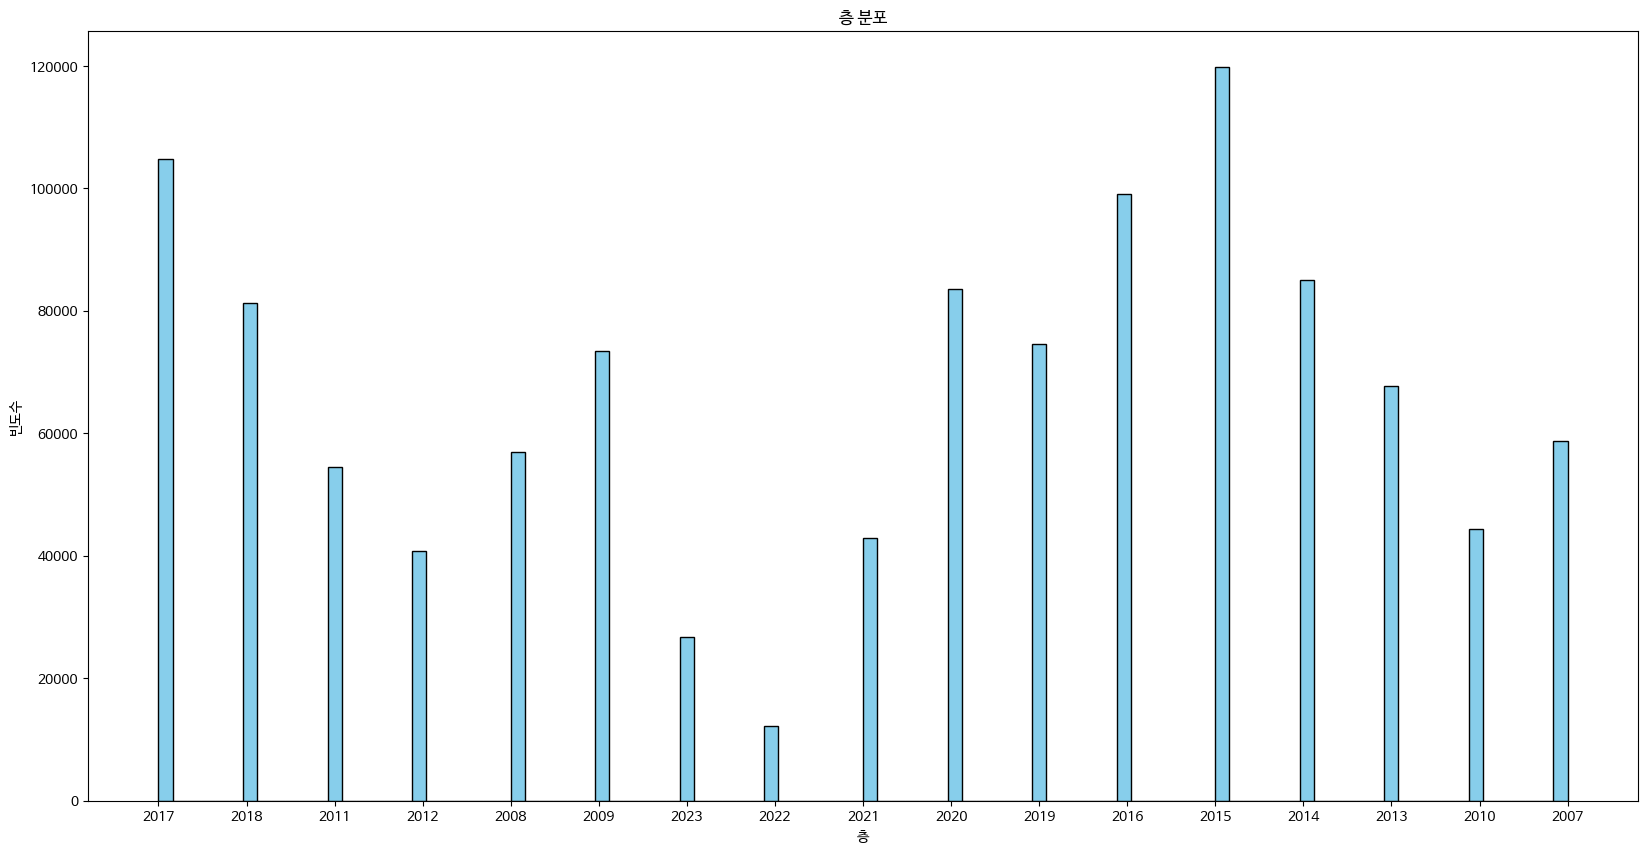

KeyError: ''

In [47]:
plt.figure(figsize=(20,10))
plt.hist(concat_select['계약년'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('층')
plt.ylabel('빈도수')
plt.title('층 분포')
plt.show()

print(concat_select[''])

In [47]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '구', '동', '계약년', '계약월'],
      dtype='object')

In [48]:
# concat_select['k-주거전용면적']

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [49]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [50]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다. 
concat_select['강남여부'] = is_gangnam

In [51]:
# 전용면적 범주화
bins = [0, 60, 85, 135, np.inf]
labels = ['소형', '중형', '대형', '초대형']
concat_select['평형대'] = pd.cut(concat_select['전용면적'], bins=bins, labels=labels)

In [52]:
# # 재건축 가능성 추가
# concat_select['건축연차'] = 2024 - concat_select['건축년도']
# concat_select['재건축가능'] = (concat_select['건축연차'] >= 30).astype(int)

In [ ]:
# is_test == 0인 데이터만 사용하여 계약년도별 평균 가격 계산
train_data = concat_select[concat_select['is_test'] == 0]  # is_test == 0 필터링
price_by_year = train_data.groupby('계약년')['target'].mean().reset_index()

# 계약년도별 가격 상승률 계산
price_by_year['price_increase_rate'] = price_by_year['target'].pct_change() * 100

# 첫 연도의 상승률(NaN)을 0으로 처리
price_by_year['price_increase_rate'] = price_by_year['price_increase_rate'].fillna(0)

# 가격 상승률 데이터를 concat_select 전체에 매칭
concat_select = concat_select.merge(price_by_year[['계약년', 'price_increase_rate']], on='계약년', how='left')

# 결과 확인
print(concat_select.isnull().sum())


아파트명                   0
전용면적                   0
계약일                    0
층                      3
건축년도                   0
좌표X                    0
좌표Y                    0
target                 0
is_test                0
구                      0
동                      0
계약년                    0
계약월                    0
강남여부                   0
평형대                    0
price_increase_rate    0
dtype: int64


In [54]:
# 동 등급 정하기
all = list(concat_select['동'].unique())
dong_level_1 = ['개포동', '반포동', '압구정동', '잠원동', '교북동', '잠실동', '일원동', '수서동', '홍파동', '평동', '신계동', '삼성동', '도곡동', '서빙고동', '청담동', '아현동', '성수동1가', '용산동5가', '용강동', '자곡동', '신천동', '보광동', '북아현동', '한남동', '이촌동', '성수동2가', '용문동', '금호동1가', '현석동', '신원동', '옥수동', '상수동', '고덕동', '역삼동', '대치동', '세곡동', '금호동2가', '장지동', '금호동4가', '신정동', '서초동', '순화동', '방배동', '내곡동', '광장동', '흑석동', '한강로3가', '원효로4가', '여의도동', '논현동', '상왕십리동', '우면동', '효창동', '상일동', '방이동', '행당동', '대흥동', '원효로1가', '목동', '도원동', '중림동', '동자동', '하왕십리동', '염리동', '만리동1가', '토정동', '신공덕동', '신사동', '공덕동', '동작동', '영등포동7가', '명일동', '하중동', '창전동', '산천동', '송파동', '삼선동3가', '문배동', '당산동5가', '풍납동', '자양동', '마곡동', '이태원동', '응봉동', '남대문로5가', '한강로2가', '효제동', '보문동6가', '당산동4가', '본동', '연지동', '연건동', '가락동', '도화동', '동소문동5가', '남가좌동', '문정동', '상도동', '사직동', '금호동3가']
dong_level_2 = [x for x in all if x not in dong_level_1]

assert len(all) == len(dong_level_1) + len(dong_level_2)       # 알맞게 분리되었는지 체크합니다.

In [55]:
# 동 등급 분류 체크
dong_level = []
for x in concat_select['동'].tolist() :
  if x in dong_level_1 :
    dong_level.append(1)
  else :
    dong_level.append(2)

# 파생변수를 하나 만듭니다.
concat_select['동등급'] = dong_level

In [56]:
# 브랜드 키워드 리스트
keywords = ['힐스테이트', '롯데캐슬', '푸르지오', '래미안', 'e편한', '위브', '더샵', '아이파크', '수자인',
            '아테라', '자이', '서희스타힐스', '에피트', '호반베르디움', '하늘채', '더플래티넘', '우미린', 
            '코아루', '센트레빌', '한화포레나', '스위첸', 'SK뷰', '리슈빌', '동문굿모닝힐', '데시앙', '벽산블루밍']

# 조건에 따라 '브랜드등급' 컬럼 값 추가
concat_select['브랜드등급'] = concat_select['아파트명'].apply(
    lambda x: 1 if any(keyword in x for keyword in keywords) else 2
)

In [57]:
# 한강벨트
hangang = ['광장동', '구의동', '자양동', '성수동2가', '성수동1가', '금호동4가', '옥수동', '한남동', '보광동', '동빙고동', '서빙고동', '이촌동', '원효로4가', '청암동', '마포동', '토정동', '용강동', '현석동', '신정동', '하중동', '상수동', '당인동', '합정동', '망원동', '상암동', '가양동', '염창동', '양화동', '당산동', '양평동6가', '양평동5가', '양평동4가', '당산동6가', '당산동5가', '당산동', '여의도동', '본동', '흑석동', '동작동', '반포동', '잠원동', '아쿠정동', '신사동', '청담동', '삼성동', '잠실동', '신천동', '풍납동', '천호동', '암사동', '고덕동', '강일동']

hangang_belt = []

for name in concat_select['동']:
    if any(keyword in name for keyword in hangang):
        hangang_belt.append(1)  # 키워드 포함 시 등급 1
    else:
        hangang_belt.append(2)  # 키워드 미포함 시 등급 2

# 결과를 데이터프레임의 '브랜드등급' 컬럼에 추가
concat_select['한강근접여부'] = hangang_belt

In [ ]:
# 학군
hakgun = {
    '동대문구': '1학군', '중랑구': '1학군',
    '마포구': '2학군', '서대문구': '2학군',
    '은평구': '2학군', '구로구': '3학군',
    '금천구': '3학군', '영등포구': '3학군',
    '노원구': '4학군', '도봉구': '4학군',
    '용산구': '5학군', '종로구': '5학군',
    '중구': '5학군', '강동구': '6학군',
    '송파구': '6학군', '강서구': '7학군',
    '양천구': '7학군', '강남구': '8학군',
    '서초구': '8학군', '관악구': '9학군',
    '동작구': '9학군', '광진구': '10학군',
    '성동구': '10학군', '강북구': '11학군',
    '성북구': '11학군'
}
concat_select['학군'] = concat_select['구'].map(hakgun)

print(concat_select[['구', '학군']].head())

     구   학군
0  강남구  8학군
1  강남구  8학군
2  강남구  8학군
3  강남구  8학군
4  강남구  8학군


In [59]:
# 지하철 및 버스 데이터 가져오기
subway_data = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv')
bus_data = pd.read_csv('/data/ephemeral/home/data/bus_feature.csv')

subway_data = subway_data.rename(columns={'위도':'Y좌표'})
subway_data = subway_data.rename(columns={'경도':'X좌표'})

In [ ]:
from scipy.spatial import cKDTree
import numpy as np

# 좌표 데이터 준비
concat_coords = concat_select[['좌표X', '좌표Y']].to_numpy()  # concat_select 좌표
subway_coords = subway_data[['X좌표', 'Y좌표']].to_numpy()   # subway_data 좌표
bus_coords = bus_data[['X좌표', 'Y좌표']].to_numpy()         # bus_data 좌표

# KDTree를 사용해 가장 가까운 거리 계산
# 지하철 거리
subway_tree = cKDTree(subway_coords)
_, closest_subway_distances = subway_tree.query(concat_coords)

# 버스 거리
bus_tree = cKDTree(bus_coords)
_, closest_bus_distances = bus_tree.query(concat_coords)

# concat_select에 거리 추가
concat_select['closest_subway_distance'] = closest_subway_distances
concat_select['closest_bus_distance'] = closest_bus_distances

# 결과 확인
print(concat_select[['좌표X', '좌표Y', 'closest_subway_distance', 'closest_bus_distance']].head())


     좌표X   좌표Y  closest_subway_distance  closest_bus_distance
0 127.06 37.48                      619                 11345
1 127.06 37.48                      619                 11345
2 127.06 37.48                      619                 11345
3 127.06 37.48                      619                 11345
4 127.06 37.48                      619                 11345


In [ ]:
print(concat_select.isnull().sum())

KeyboardInterrupt: 

In [60]:
# # 아파트 데이터 준비
# apartment_data = concat_select[['아파트명', '좌표X', '좌표Y']].copy()
# apartment_data.rename(columns={'좌표X': '아파트X', '좌표Y': '아파트Y'}, inplace=True)

# # 지하철 데이터 불러오기
# subway_data = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv')
# subway_data.rename(columns={'위도': '지하철X', '경도': '지하철Y'}, inplace=True)

In [61]:
# from scipy.spatial.distance import cdist
# from sklearn.preprocessing import MinMaxScaler


# # 아파트 좌표와 지하철 좌표 추출
# apartment_coords = apartment_data[['아파트X', '아파트Y']].to_numpy()
# subway_coords = subway_data[['지하철X', '지하철Y']].to_numpy()

# # 모든 아파트와 지하철 간 거리 계산 (벡터화)
# distances = cdist(apartment_coords, subway_coords)

# # 각 아파트와 가장 가까운 지하철 거리 찾기
# nearest_distances = distances.min(axis=1)

# # 결과 저장
# concat_select['지하철거리'] = nearest_distances

# # 결과 데이터프레임에서 지하철 거리 추출
# distances = concat_select['지하철거리'].values.reshape(-1, 1)

# # 정규화 (MinMaxScaler 사용)
# scaler = MinMaxScaler()
# normalized_distances = scaler.fit_transform(distances)

# # 정규화된 값을 새로운 컬럼으로 저장
# concat_select['지하철거리'] = normalized_distances

# # 결과 확인
# print(concat_select[['아파트명', '지하철거리']].head())



In [62]:
# 금리 칼럼 추가
rate_data = [
    {'변경일자': '2024-11-28', '기준금리': 3.00}, {'변경일자': '2024-10-11', '기준금리': 3.25},
    {'변경일자': '2023-01-13', '기준금리': 3.50}, {'변경일자': '2022-11-24', '기준금리': 3.25},
    {'변경일자': '2022-10-12', '기준금리': 3.00}, {'변경일자': '2022-08-25', '기준금리': 2.50},
    {'변경일자': '2022-07-13', '기준금리': 2.25}, {'변경일자': '2022-05-26', '기준금리': 1.75},
    {'변경일자': '2022-04-14', '기준금리': 1.50}, {'변경일자': '2022-01-14', '기준금리': 1.25},
    {'변경일자': '2021-11-25', '기준금리': 1.00}, {'변경일자': '2021-08-26', '기준금리': 0.75},
    {'변경일자': '2020-05-28', '기준금리': 0.50}, {'변경일자': '2020-03-17', '기준금리': 0.75},
    {'변경일자': '2019-10-16', '기준금리': 1.25}, {'변경일자': '2019-07-18', '기준금리': 1.50},
    {'변경일자': '2018-11-30', '기준금리': 1.75}, {'변경일자': '2017-11-30', '기준금리': 1.50},
    {'변경일자': '2016-06-09', '기준금리': 1.25}, {'변경일자': '2015-06-11', '기준금리': 1.50},
    {'변경일자': '2015-03-12', '기준금리': 1.75}, {'변경일자': '2014-10-15', '기준금리': 2.00},
    {'변경일자': '2014-08-14', '기준금리': 2.25}, {'변경일자': '2013-05-09', '기준금리': 2.50},
    {'변경일자': '2012-10-11', '기준금리': 2.75}, {'변경일자': '2012-07-12', '기준금리': 3.00},
    {'변경일자': '2011-06-10', '기준금리': 3.25}, {'변경일자': '2011-03-10', '기준금리': 3.00},
    {'변경일자': '2011-01-13', '기준금리': 2.75}, {'변경일자': '2010-11-16', '기준금리': 2.50},
    {'변경일자': '2010-07-09', '기준금리': 2.25}, {'변경일자': '2009-02-12', '기준금리': 2.00},
    {'변경일자': '2009-01-09', '기준금리': 2.50}, {'변경일자': '2008-12-11', '기준금리': 3.00},
    {'변경일자': '2008-11-07', '기준금리': 4.00}, {'변경일자': '2008-10-27', '기준금리': 4.25},
    {'변경일자': '2008-10-09', '기준금리': 5.00}, {'변경일자': '2008-08-07', '기준금리': 5.25},
    {'변경일자': '2007-08-09', '기준금리': 5.00}, {'변경일자': '2007-07-12', '기준금리': 4.75},
    {'변경일자': '2006-08-10', '기준금리': 4.50}, {'변경일자': '2006-06-08', '기준금리': 4.25},
    {'변경일자': '2006-02-09', '기준금리': 4.00}, {'변경일자': '2005-12-08', '기준금리': 3.75},
    {'변경일자': '2005-10-11', '기준금리': 3.50}, {'변경일자': '2004-11-11', '기준금리': 3.25},
    {'변경일자': '2004-08-12', '기준금리': 3.50}, {'변경일자': '2003-07-10', '기준금리': 3.75},
    {'변경일자': '2003-05-13', '기준금리': 4.00}, {'변경일자': '2002-05-07', '기준금리': 4.25},
    {'변경일자': '2001-09-19', '기준금리': 4.00}, {'변경일자': '2001-08-09', '기준금리': 4.50},
    {'변경일자': '2001-07-05', '기준금리': 4.75}, {'변경일자': '2001-02-08', '기준금리': 5.00},
    {'변경일자': '2000-10-05', '기준금리': 5.25}, {'변경일자': '2000-02-10', '기준금리': 5.00},
    {'변경일자': '1999-05-06', '기준금리': 4.75},
]

# 금리 데이터프레임 생성
rate_df = pd.DataFrame(rate_data)
rate_df['변경일자'] = pd.to_datetime(rate_df['변경일자'])

# 계약일자 생성
concat_select['계약일자'] = pd.to_datetime(
    concat_select['계약년'].astype(str) + '-' +
    concat_select['계약월'].astype(str) + '-' +
    concat_select['계약일'].astype(str)
)

# 금리 매핑 함수
def find_rate_no_sort(date, rate_list):
    for rate in rate_list:
        if rate['변경일자'] <= date:
            return rate['기준금리']
    return rate_list[-1]['기준금리']  # 모든 날짜보다 과거일 경우 가장 오래된 금리 반환

# 금리 매핑 (정렬 없이 처리)
rate_list = rate_df.to_dict('records')  # 데이터프레임을 리스트로 변환
concat_select['기준금리'] = concat_select['계약일자'].apply(lambda x: find_rate_no_sort(x, rate_list))

# 계약일자 삭제
del concat_select['계약일자']

# 결과 확인
print(concat_select[['기준금리']])

         기준금리
0        1.50
1        1.50
2        1.50
3        1.50
4        1.50
...       ...
1126551  3.50
1126552  3.50
1126553  3.50
1126554  3.50
1126555  3.50

[1126556 rows x 1 columns]


In [63]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '구', '동', '계약년', '계약월', '강남여부', '평형대', 'price_increase_rate', '동등급',
       '브랜드등급', '한강근접여부', '학군', 'closest_subway_distance',
       'closest_bus_distance', '기준금리'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [64]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.99])

count   1126556.00
mean       1998.78
std           9.36
min        1961.00
10%        1986.00
25%        1992.00
50%        2000.00
75%        2005.00
80%        2006.00
99%        2018.00
max        2023.00
Name: 건축년도, dtype: float64

In [65]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2018 else 0)

In [66]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,is_test,구,...,평형대,price_increase_rate,동등급,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부
0,개포6차우성,8.94,8,1.10,1987,127.06,37.48,124000.00,0,강남구,...,소형,16.05,1,2,2,8학군,619,11345,1.50,0


In [67]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '구', '동', '계약년', '계약월', '강남여부', '평형대', 'price_increase_rate', '동등급',
       '브랜드등급', '한강근접여부', '학군', 'closest_subway_distance',
       'closest_bus_distance', '기준금리', '신축여부'],
      dtype='object')

없앨 목록  
등기신청일자, 거래유형, 중개사소재지, k-전화번호, k-팩스번호, 단지소개기존clob, k-관리방식, k-전용면적별세대현황(60㎡이하), 
k-전용면적별세대현황(60㎡~85㎡이하), k-85㎡~135㎡이하, k-135㎡초과, k-홈페이지, k-등록일자, k-수정일자, 고용보험관리번호,
단지승인일, 사용허가여부, 관리비 업로드, 단지신청일

In [68]:
# # 필요 없는 변수 삭제
# del concat_select['본번']
# del concat_select['부번']
# del concat_select['고용보험관리번호']
# del concat_select['k-수정일자']
# del concat_select['k-전화번호']
# del concat_select['k-팩스번호']
# del concat_select['k-연면적']
# del concat_select['k-관리비부과면적']
# del concat_select['번지']
# del concat_select['사용허가여부']
# del concat_select['k-전용면적별세대현황(60㎡~85㎡이하)']
# del concat_select['k-전용면적별세대현황(60㎡이하)']

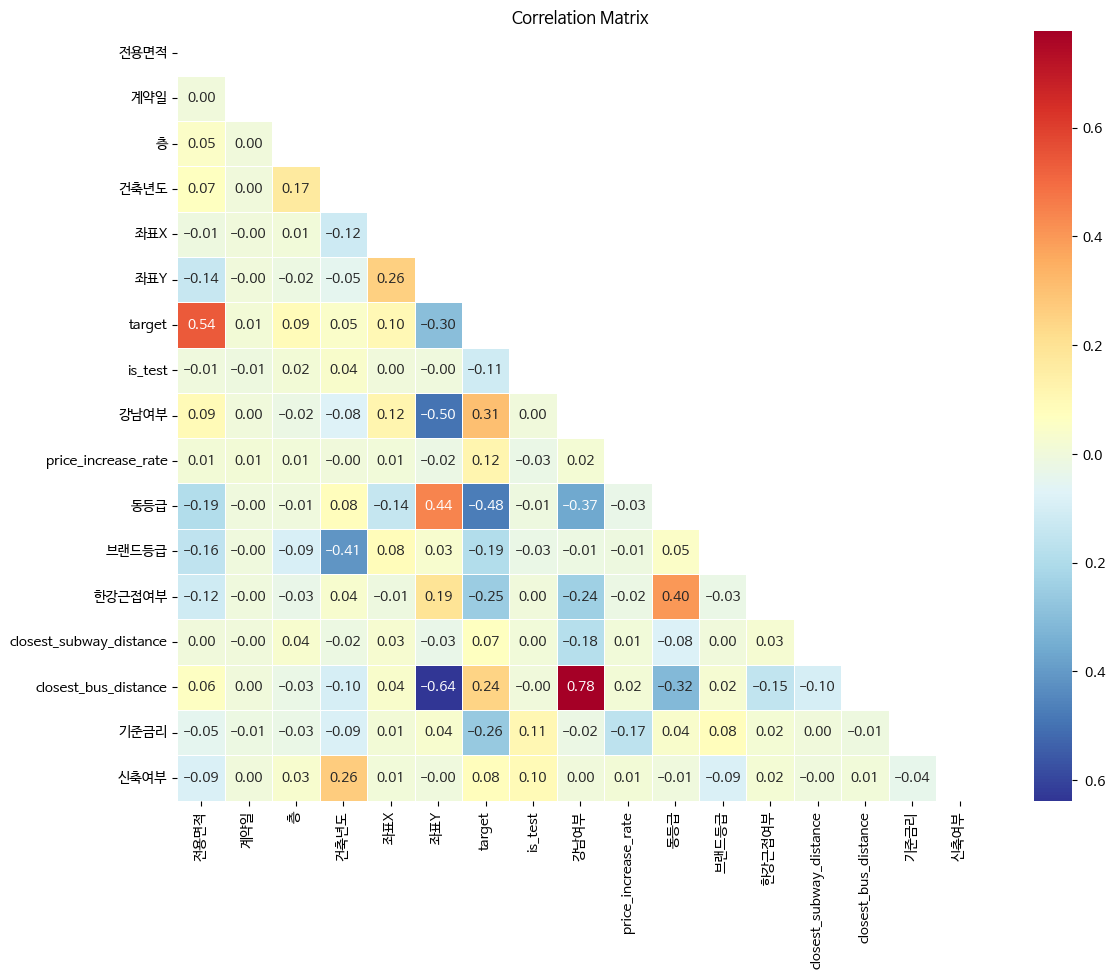

In [69]:
# 데이터의 상관계수 행렬을 생성
corr = concat_select.corr(numeric_only=True)  # 데이터셋으로부터 각 변수별 상관계수를 계산하여 행렬형태로 나타내는 함수. 여기서는 피어슨 상관계수를 이용
# numeric_only는 숫자형 변수만 상관계수를 계산하도록 하는 옵션
# figure에서 생략될 부분을 지정하는 mask 행렬을 생성 - 실제로는 mask 없이 다 생성해도 괜찮습니다.
mask = np.ones_like(corr, dtype=bool)
mask = np.triu(mask)

# 시각화될 그림의 크기를 지정
# 히트맵 형태로 상관행렬 시각화하기
plt.figure(figsize=(13,10))
sns.heatmap(data=corr, annot=True, fmt='.2f', mask=mask, linewidths=.5, cmap='RdYlBu_r')
plt.title('Correlation Matrix')
plt.show()

In [70]:
# print(concat_select['k-사용검사일-사용승인일'], concat_select['단지승인일'], concat_select['단지신청일'])

In [71]:
concat_select['is_test']

0          0
1          0
2          0
3          0
4          0
          ..
1126551    1
1126552    1
1126553    1
1126554    1
1126555    1
Name: is_test, Length: 1126556, dtype: int64

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

In [72]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(concat_select)
preds_df.to_csv('../data/datafix.csv', index=False)